In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import display, HTML

from google_auth_oauthlib import flow
from google.cloud import bigquery

#%matplotlib notebook

# Use the client credentials to perform the OAuth 2.0 flow.

In [ ]:
# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = True
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    'Insert your google bigquery oath2 API',
    scopes=['https://www.googleapis.com/auth/bigquery'])

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=462168211200-uufspd1k558a7kqdkgokk3hmn4rktlsv.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=c59OandHwUGWkd5QvqnyU2sN0FFuWy&access_type=offline&code_challenge=GNukUO9qnXgUmGpdxoDPkxeBqlyyHey7GJXYK2U1xQw&code_challenge_method=S256


# Use the authenticated credentials to connect to the BigQuery API.

In [ ]:
# TODO: Uncomment the line below to set the `project` variable.
project = 'insert your project here'
#
# The `project` variable defines the project to be billed for query
# processing. The user must have the bigquery.jobs.create permission on
# this project to run a query. See:
# https://cloud.google.com/bigquery/docs/access-control#permissions

client = bigquery.Client(project=project, credentials=credentials)

# Exploratory Analysis

#### First let's run the following query to produce data to generate a histrogram graph to show the distribution of patient ages in ten-year buckets (i.e. [0, 10), [10, 20), ..., [90, ∞).

In [ ]:
query_string = """WITH ps AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    DATETIME_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
  FROM `physionet-data.mimiciii_clinical.icustays` AS icu
  INNER JOIN `physionet-data.mimiciii_clinical.patients` AS pat
    ON icu.subject_id = pat.subject_id),
bu AS (
  SELECT
    CAST(FLOOR(age / 10) AS INT64) AS bucket
  FROM ps)
SELECT
  COUNT(bucket) AS num_icu_stays,
  IF(bucket >= 9, ">= 90", FORMAT("%d - %d", bucket * 10, (bucket + 1) * 10)) AS age_bucket
FROM bu
GROUP BY bucket
ORDER BY bucket ASC
"""
query_job = client.query(query_string).to_dataframe()

In [ ]:
query_job.set_index('age_bucket').plot(title='stay - age', kind='bar', legend=False)

#### Now let's see if there is correlation between age and average length of stay in hours. Since we are using the age of patients when they get admitted, so we don't need to worry about multiple admissions of patients. Note that we treat the redacted ages (> 90) as noises and filter them out.

In [6]:
query_string2 ="""WITH re AS (
SELECT
  DATETIME_DIFF(icu.outtime, icu.intime, HOUR) AS icu_length_of_stay,
  DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age
FROM `physionet-data.mimiciii_clinical.icustays` AS icu
INNER JOIN `physionet-data.mimiciii_clinical.patients` AS pat
  ON icu.subject_id = pat.subject_id)
SELECT
  icu_length_of_stay AS stay,
  age
FROM re
WHERE age < 100
"""

query_job2 = client.query(query_string2).to_dataframe()

In [7]:
query_job2.head()

,stay,age
0,77.0,25
1,37.0,25
2,47.0,89
3,61.0,31
4,59.0,23


on top say by age

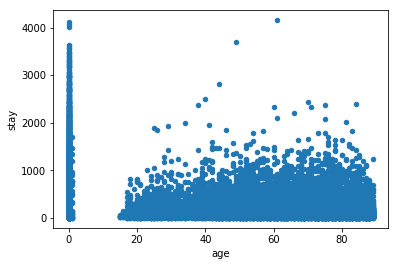

In [8]:
query_job2.plot(kind='scatter', x='age', y='stay')

There's seem to be a slight correlation between lenght of stay ant patient age

#### The current service that ICU patients are undergoing

In [3]:
currentServices_query = """WITH co AS (
  SELECT
    icu.subject_id,
    icu.hadm_id,
    icu.icustay_id,
    pat.dob,
    DATETIME_DIFF(icu.outtime, icu.intime, DAY) AS icu_length_of_stay,
    DATE_DIFF(DATE(icu.intime), DATE(pat.dob), YEAR) AS age,
    RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
  FROM `physionet-data.mimiciii_clinical.icustays` AS icu
  INNER JOIN `physionet-data.mimiciii_clinical.patients` AS pat
    ON icu.subject_id = pat.subject_id
  ORDER BY hadm_id DESC),
serv AS (
  SELECT
    icu.hadm_id,
    icu.icustay_id,
    se.curr_service,
    IF(curr_service like '%SURG' OR curr_service = 'ORTHO', 1, 0) AS surgical,
    RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
  FROM `physionet-data.mimiciii_clinical.icustays` AS icu
  LEFT JOIN `physionet-data.mimiciii_clinical.services` AS se
   ON icu.hadm_id = se.hadm_id
  AND se.transfertime < DATETIME_ADD(icu.intime, INTERVAL 12 HOUR)
  ORDER BY icustay_id)
SELECT
  co.subject_id,
  co.hadm_id,
  co.icustay_id,
  co.icu_length_of_stay,
  co.age,
  IF(co.icu_length_of_stay < 2, 1, 0) AS short_stay,
  IF(co.icustay_id_order = 1, 0, 1) AS first_stay,
  IF(serv.surgical = 1, 1, 0) AS surgical
FROM co
LEFT JOIN serv USING (icustay_id, hadm_id)
WHERE
  serv.rank = 1 AND age < 100
ORDER BY subject_id, icustay_id_order"""

currentServices_df = client.query(currentServices_query).to_dataframe()

NameError: name 'client' is not defined


This is a long query, but is pretty simple if we take a closer look. It consists of 3 steps as well:
    1. We are trying to know how many ICU admissions each patient has by joining icustays and patients. Note that since each patient may be admitted multiple times, we usually filter out follow-up ICU stays, and only keep the first one to minimize unwanted data correlation. This is achieved by partitioning over subject_id, and ordering by admission time, then choose only the first one with RANK function, the result is saved to a temporary table co;
    2. Next we are looking for first services in ICU stays for patients, and also adding a label to indicate whether last services before ICU admission were surgical, similarly the result is saved to serv;
    3. Lastly, we are ready to save this surgical exclusion label to a cohort generation table by joining the two tables, co and serv. For the convenience of later analysis, we rename some columns, and filter out patients more than 100 years old.



In [10]:
currentServices_df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,short_stay,first_stay,surgical
0,2,163353,243653,0.0,0,1,0,0
1,3,145834,211552,6.0,76,0,0,1
2,4,185777,294638,1.0,48,1,0,0
3,5,178980,214757,0.0,0,1,0,0
4,6,107064,228232,4.0,66,0,0,1


In [11]:
currentServices_df.icu_length_of_stay.mean()

4.9288672477429865

The average service time is 4.92 days

In [1]:
currentServices_df.icu_length_of_stay.plot(kind='hist')

NameError: name 'currentServices_df' is not defined

#### Checking for distribution of Biological Sex

In [13]:
sex_string = """
SELECT 
    GENDER, 
    COUNT(*) AS Count
FROM 
    `physionet-data.mimiciii_clinical.patients`
GROUP BY 
    GENDER;
"""
sex_df = client.query(sex_string).to_dataframe()

In [14]:
sex_df.head()

,GENDER,Count
0,F,20399
1,M,26121


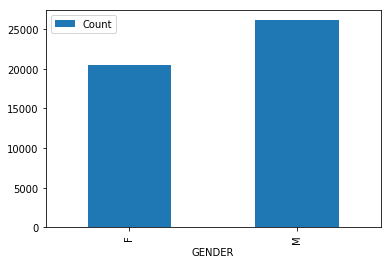

In [15]:
sex_df.plot(x='GENDER',y='Count', kind='bar')

#### Checking for different enthicities available

In [16]:
et_string = """
SELECT
  ETHNICITY,
  COUNT(*) AS `Count`
FROM
 `physionet-data.mimiciii_clinical.admissions`
GROUP BY
  ETHNICITY
"""
query_et = client.query(et_string).to_dataframe()

In [17]:
query_et['percentage'] = (query_et['Count']/query_et['Count'].sum()) * 100
display(query_et)

,ETHNICITY,Count,percentage
0,WHITE,40996,69.513022
1,BLACK/AFRICAN AMERICAN,5440,9.224091
2,HISPANIC/LATINO - PUERTO RICAN,232,0.393380
3,OTHER,1512,2.563755
4,ASIAN,1509,2.558668
5,HISPANIC OR LATINO,1696,2.875746
6,UNKNOWN/NOT SPECIFIED,4523,7.669221
7,PATIENT DECLINED TO ANSWER,559,0.947843
8,ASIAN - CHINESE,277,0.469683
9,AMERICAN INDIAN/ALASKA NATIVE,51,0.086476


In [18]:
admissionType_string = """
SELECT 
    ADMISSION_TYPE , 
    COUNT(*) AS Count
FROM 
    `physionet-data.mimiciii_clinical.admissions`
GROUP BY 
    ADMISSION_TYPE;"""
admissionType_df = client.query(admissionType_string).to_dataframe()

In [19]:
display(admissionType_df)

,ADMISSION_TYPE,Count
0,EMERGENCY,42071
1,ELECTIVE,7706
2,URGENT,1336
3,NEWBORN,7863


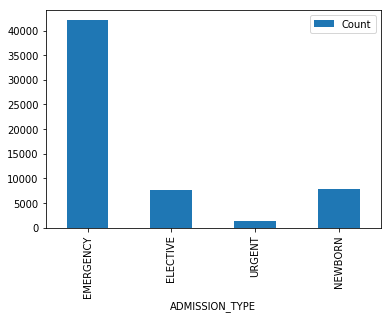

In [20]:
admissionType_df.plot(x='ADMISSION_TYPE',y='Count',kind='bar')

In [21]:
adm_diag_string = """
SELECT
  diagnosis,
  COUNT(*) AS `Count`
FROM
 `physionet-data.mimiciii_clinical.admissions`
GROUP BY
  diagnosis
ORDER BY Count DESC
"""
adm_diag_df = client.query(adm_diag_string).to_dataframe()

In [22]:
adm_diag_df['percentage'] = (adm_diag_df['Count']/adm_diag_df['Count'].sum()) * 100
display(adm_diag_df)

,diagnosis,Count,percentage
0,NEWBORN,7823,13.264718
1,PNEUMONIA,1566,2.655317
2,SEPSIS,1184,2.007596
3,CONGESTIVE HEART FAILURE,928,1.573521
4,CORONARY ARTERY DISEASE,840,1.424308
5,CHEST PAIN,778,1.319181
6,INTRACRANIAL HEMORRHAGE,713,1.208966
7,ALTERED MENTAL STATUS,712,1.207271
8,GASTROINTESTINAL BLEED,686,1.163185
9,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,583,0.988538


In [23]:
insurance_string = """
SELECT
    insurance,
    COUNT(*) AS `Count`
FROM
 `physionet-data.mimiciii_clinical.admissions`
GROUP BY
  	insurance
ORDER BY Count DESC
"""
insurance_df = client.query(insurance_string).to_dataframe()

In [24]:
insurance_df['percentage'] = (insurance_df['Count']/insurance_df['Count'].sum()) * 100
display(insurance_df)

,insurance,Count,percentage
0,Medicare,28215,47.841495
1,Private,22582,38.290152
2,Medicaid,5785,9.809075
3,Government,1783,3.023264
4,Self Pay,611,1.036015


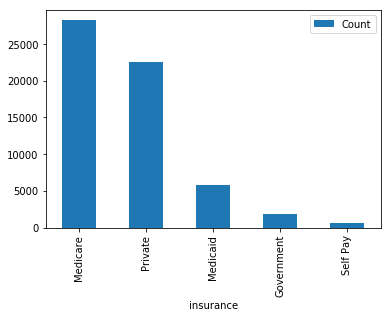

In [25]:
insurance_df.plot(x='insurance',y='Count',kind='bar')

In [26]:
religion_string = """
SELECT
    religion,
    COUNT(*) AS `Count`
FROM
 `physionet-data.mimiciii_clinical.admissions`
GROUP BY
  	religion
ORDER BY Count DESC
"""
religion_df = client.query(religion_string).to_dataframe()

In [27]:
religion_df['percentage'] = (religion_df['Count']/religion_df['Count'].sum()) * 100
display(religion_df)

,religion,Count,percentage
0,CATHOLIC,20606,34.939636
1,NOT SPECIFIED,11753,19.928445
2,UNOBTAINABLE,8269,14.020958
3,PROTESTANT QUAKER,7134,12.096446
4,JEWISH,5314,9.010445
5,OTHER,2696,4.571351
6,EPISCOPALIAN,774,1.312398
7,GREEK ORTHODOX,459,0.778283
8,None,458,0.776587
9,CHRISTIAN SCIENTIST,429,0.727415


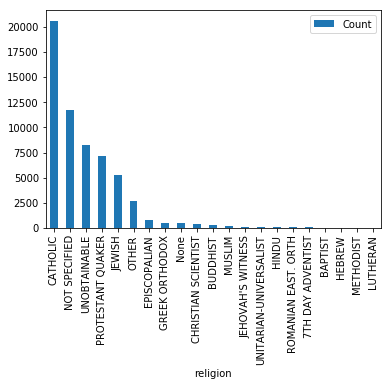

In [28]:
religion_df.plot(x='religion',y='Count',kind='bar')

In [29]:
marital_status_string = """
SELECT
    marital_status,
    COUNT(*) AS `Count`
FROM
 `physionet-data.mimiciii_clinical.admissions`
GROUP BY
  	marital_status
ORDER BY Count DESC
"""
marital_status_df = client.query(marital_status_string).to_dataframe()

In [30]:
marital_status_df['percentage'] = (marital_status_df['Count']/marital_status_df['Count'].sum()) * 100
display(marital_status_df)

,marital_status,Count,percentage
0,MARRIED,24239,41.099769
1,SINGLE,13254,22.473549
2,None,10128,17.173087
3,WIDOWED,7211,12.227008
4,DIVORCED,3213,5.447979
5,SEPARATED,571,0.968190
6,UNKNOWN (DEFAULT),345,0.584984
7,LIFE PARTNER,15,0.025434


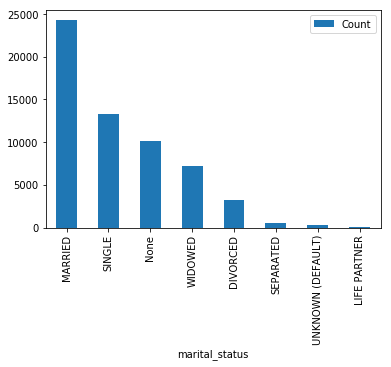

In [31]:
marital_status_df.plot(x='marital_status',y='Count',kind='bar')

In [32]:
deadHos_string = """
WITH exp_hos AS (SELECT 
  SUBJECT_ID,
  EXPIRE_FLAG
FROM 
  `physionet-data.mimiciii_clinical.patients` p1
  WHERE SUBJECT_ID IN (
    SELECT
      SUBJECT_ID
    FROM
      `physionet-data.mimiciii_clinical.patients` p2
    WHERE p2.DOD_HOSP IS NOT NULL 
    )
 )

SELECT exp_hos.EXPIRE_FLAG, COUNT(*) AS Count
  FROM `physionet-data.mimiciii_clinical.patients` p
  LEFT JOIN exp_hos ON 
    p.SUBJECT_ID = exp_hos.SUBJECT_ID AND p.EXPIRE_FLAG = exp_hos.EXPIRE_FLAG
  GROUP BY EXPIRE_FLAG
"""

In [33]:
deadHos_df = client.query(deadHos_string).to_dataframe().fillna(0)

In [34]:
deadHos_df['percentage'] = (deadHos_df['Count']/deadHos_df['Count'].sum()) * 100
display(deadHos_df)

,EXPIRE_FLAG,Count,percentage
0,0.0,36546,78.559759
1,1.0,9974,21.440241


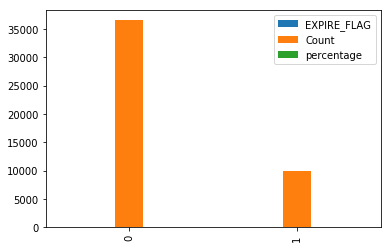

In [35]:
deadHos_df.plot(kind='bar')

In [36]:
deadHos_diag_string = """
WITH exp_hos AS (SELECT 
  SUBJECT_ID,
  EXPIRE_FLAG
FROM 
  `physionet-data.mimiciii_clinical.patients` p1
  WHERE SUBJECT_ID IN (
    SELECT
      SUBJECT_ID
    FROM
      `physionet-data.mimiciii_clinical.patients` p2
    WHERE p2.DOD_HOSP IS NOT NULL 
    )
 )

SELECT a.DIAGNOSIS , COUNT(*) AS Count
  FROM `physionet-data.mimiciii_clinical.admissions` a
    LEFT JOIN exp_hos ON 
      a.SUBJECT_ID = exp_hos.SUBJECT_ID
  WHERE 
    exp_hos.EXPIRE_FLAG = 1
  GROUP BY a.DIAGNOSIS
  ORDER BY Count DESC
"""
deadHos_diag_df = client.query(deadHos_diag_string).to_dataframe()

In [37]:
deadHos_diag_df['percentage'] = (deadHos_diag_df['Count']/deadHos_diag_df['Count'].sum()) * 100
display(deadHos_diag_df)

,DIAGNOSIS,Count,percentage
0,PNEUMONIA,691,4.584965
1,SEPSIS,523,3.470241
2,CONGESTIVE HEART FAILURE,450,2.985867
3,INTRACRANIAL HEMORRHAGE,280,1.857873
4,GASTROINTESTINAL BLEED,232,1.539380
5,ALTERED MENTAL STATUS,226,1.499569
6,FEVER,204,1.353593
7,ABDOMINAL PAIN,199,1.320417
8,CHEST PAIN,197,1.307146
9,HYPOTENSION,176,1.167806


# Generate the dyspena patient subset

In [4]:
dispenea_string = """
SELECT icd.ICD9_CODE, dicd.SHORT_TITLE, count(icd.ICD9_CODE) AS Count
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` icd
LEFT JOIN  `physionet-data.mimiciii_clinical.d_icd_diagnoses` dicd
ON icd.ICD9_CODE = dicd.ICD9_CODE
WHERE icd.ICD9_CODE LIKE "7860%" GROUP BY ICD9_CODE, dicd.SHORT_TITLE  ORDER BY ICD9_CODE
"""

dispnea_df = client.query(dispenea_string).to_dataframe()

In [5]:
display(dispnea_df)

,ICD9_CODE,SHORT_TITLE,Count
0,78600,Respiratory abnorm NOS,1
1,78601,Hyperventilation,3
2,78602,Orthopnea,4
3,78603,Apnea,55
4,78604,Cheyne-stokes respiratn,12
5,78605,Shortness of breath,39
6,78606,Tachypnea,54
7,78607,Wheezing,7
8,78609,Respiratory abnorm NEC,166


In [8]:
dispnea_exp_string = """

WITH exp_hos AS (
SELECT SUBJECT_ID, EXPIRE_FLAG
FROM `physionet-data.mimiciii_clinical.patients` p1
  WHERE SUBJECT_ID IN (
    SELECT SUBJECT_ID
    FROM `physionet-data.mimiciii_clinical.patients` p2
    WHERE p2.DOD_HOSP IS NOT NULL 
    )
 ),

dyspnea AS( 
SELECT icd.SUBJECT_ID, icd.ICD9_CODE, dicd.SHORT_TITLE
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` icd
LEFT JOIN  `physionet-data.mimiciii_clinical.d_icd_diagnoses` dicd
ON icd.ICD9_CODE = dicd.ICD9_CODE
WHERE icd.ICD9_CODE LIKE "7860%")

SELECT dyspnea.ICD9_CODE,dyspnea.SHORT_TITLE, count(*) AS Count
FROM dyspnea 
LEFT JOIN exp_hos
ON dyspnea.SUBJECT_ID  = exp_hos.SUBJECT_ID
WHERE  exp_hos.EXPIRE_FLAG = 1
GROUP BY dyspnea.ICD9_CODE, dyspnea.SHORT_TITLE
ORDER BY Count DESC
"""

dispnea_exp_df = client.query(dispnea_exp_string).to_dataframe()

In [9]:
display(dispnea_exp_df)

,ICD9_CODE,SHORT_TITLE,Count
0,78609,Respiratory abnorm NEC,49
1,78606,Tachypnea,17
2,78604,Cheyne-stokes respiratn,7
3,78605,Shortness of breath,7
4,78603,Apnea,6
5,78601,Hyperventilation,2


In [10]:
dispnea_alive_string = """WITH exp_hos AS (
SELECT SUBJECT_ID, EXPIRE_FLAG
FROM `physionet-data.mimiciii_clinical.patients` p1
  WHERE SUBJECT_ID IN (
    SELECT SUBJECT_ID
    FROM `physionet-data.mimiciii_clinical.patients` p2
    WHERE p2.DOD_HOSP IS NOT NULL 
    )
 ),

dyspnea AS( 
SELECT icd.SUBJECT_ID, icd.ICD9_CODE, dicd.SHORT_TITLE
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` icd
LEFT JOIN  `physionet-data.mimiciii_clinical.d_icd_diagnoses` dicd
ON icd.ICD9_CODE = dicd.ICD9_CODE
WHERE icd.ICD9_CODE LIKE "7860%")

SELECT dyspnea.ICD9_CODE,dyspnea.SHORT_TITLE, count(*) AS Count
FROM dyspnea 
LEFT JOIN exp_hos
ON dyspnea.SUBJECT_ID  = exp_hos.SUBJECT_ID
WHERE exp_hos.EXPIRE_FLAG IS NULL
GROUP BY dyspnea.ICD9_CODE, dyspnea.SHORT_TITLE
ORDER BY Count DESC"""

dispnea_alive_df = client.query(dispnea_alive_string).to_dataframe()

In [11]:
display(dispnea_alive_df)

,ICD9_CODE,SHORT_TITLE,Count
0,78609,Respiratory abnorm NEC,117
1,78603,Apnea,49
2,78606,Tachypnea,37
3,78605,Shortness of breath,32
4,78607,Wheezing,7
5,78604,Cheyne-stokes respiratn,5
6,78602,Orthopnea,4
7,78601,Hyperventilation,1
8,78600,Respiratory abnorm NOS,1


In [13]:
dysp_all_diag_hist_str = """
WITH dysp AS (SELECT icd.SUBJECT_ID ,icd.HADM_ID, icd.ICD9_CODE,ADMITTIME , DISCHTIME,pat.GENDER, DATE_DIFF(DATE(a.ADMITTIME), DATE(pat.dob), YEAR) AS age
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` icd
LEFT JOIN `physionet-data.mimiciii_clinical.admissions` a
ON icd.SUBJECT_ID = a.SUBJECT_ID  AND icd.HADM_ID = a.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.patients` AS pat
ON icd.SUBJECT_ID = pat.SUBJECT_ID
WHERE icd.ICD9_CODE LIKE "7860%"
ORDER BY icd.SUBJECT_ID),

ALL_DYSP AS (
SELECT icd.SUBJECT_ID ,icd.HADM_ID, icd.ICD9_CODE, dicd.SHORT_TITLE, icd.SEQ_NUM, a.DIAGNOSIS, a.ADMITTIME , a.DISCHTIME, a.DEATHTIME,  dysp.GENDER, a.ETHNICITY,a.marital_status,dysp.age, a.religion, (pro.ICD9_CODE) AS Pro_ICD9, (dpro.SHORT_TITLE) As PRO_SHORT_TITLE
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd` icd
    LEFT JOIN `physionet-data.mimiciii_clinical.d_icd_diagnoses` dicd
      ON icd.ICD9_CODE = dicd.ICD9_CODE
    LEFT JOIN `physionet-data.mimiciii_clinical.admissions` a
      ON icd.SUBJECT_ID = a.SUBJECT_ID  AND icd.HADM_ID = a.HADM_ID
    LEFT JOIN dysp
      ON icd.SUBJECT_ID = dysp.SUBJECT_ID  AND icd.HADM_ID = dysp.HADM_ID
      LEFT JOIN `physionet-data.mimiciii_clinical.procedures_icd` pro
    ON icd.SUBJECT_ID = pro.SUBJECT_ID and icd.HADM_ID = pro.HADM_ID
    LEFT JOIN `physionet-data.mimiciii_clinical.d_icd_procedures` dpro
    ON pro.ICD9_CODE = dpro.ICD9_CODE 
WHERE (icd.SUBJECT_ID IN 
      (SELECT SUBJECT_ID FROM dysp))
ORDER BY SUBJECT_ID , HADM_ID)

SELECT * FROM ALL_DYSP ORDER BY SUBJECT_ID, ADMITTIME"""

dysp_all_diag_hist_df = client.query(dysp_all_diag_hist_str).to_dataframe()

In [14]:
dysp_str = '''SELECT icd.SUBJECT_ID ,icd.HADM_ID, icd.ICD9_CODE, ADMITTIME , DISCHTIME, a.DEATHTIME, a.ETHNICITY, pat.GENDER,a.marital_status, DATE_DIFF(DATE(a.ADMITTIME), DATE(pat.dob), YEAR) AS age,a.religion, dicd.SHORT_TITLE, (pro.ICD9_CODE) AS Pro_ICD9, (dpro.SHORT_TITLE) As PRO_SHORT_TITLE
FROM `physionet-data.mimiciii_clinical.diagnoses_icd` icd
LEFT JOIN `physionet-data.mimiciii_clinical.admissions` a
ON icd.SUBJECT_ID = a.SUBJECT_ID  AND icd.HADM_ID = a.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.patients` AS pat
ON icd.SUBJECT_ID = pat.SUBJECT_ID
LEFT JOIN `physionet-data.mimiciii_clinical.d_icd_diagnoses` dicd
ON icd.ICD9_CODE = dicd.ICD9_CODE
LEFT JOIN `physionet-data.mimiciii_clinical.procedures_icd` pro
ON icd.SUBJECT_ID = pro.SUBJECT_ID and icd.HADM_ID = pro.HADM_ID
LEFT JOIN `physionet-data.mimiciii_clinical.d_icd_procedures` dpro
ON pro.ICD9_CODE = dpro.ICD9_CODE 
WHERE icd.ICD9_CODE LIKE "7860%"
ORDER BY SUBJECT_ID , ADMITTIME'''

dysp_df = client.query(dysp_str).to_dataframe()

In [16]:
print(len(dysp_df.Pro_ICD9.unique()))

300


In [17]:
display(dysp_all_diag_hist_df.ETHNICITY.unique())

array(['WHITE', 'BLACK/AFRICAN AMERICAN', 'UNKNOWN/NOT SPECIFIED',
       'PATIENT DECLINED TO ANSWER', 'ASIAN - ASIAN INDIAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC OR LATINO',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'OTHER',
       'HISPANIC/LATINO - PUERTO RICAN', 'MULTI RACE ETHNICITY',
       'BLACK/CAPE VERDEAN', 'ASIAN - CHINESE', 'UNABLE TO OBTAIN',
       'HISPANIC/LATINO - MEXICAN', 'BLACK/HAITIAN', 'BLACK/AFRICAN',
       'ASIAN - CAMBODIAN'], dtype=object)

In [1]:
dysp_all_diag_hist_df = dysp_all_diag_hist_df.replace(regex={'(HISPAN)\w.*': 'HISPANIC/LATINO', '(ASI)\w.*': 'ASIAN' , '(BLA)\w.*': 'BLACK'})
for idx, row in dysp_all_diag_hist_df.iterrows():
    if(row.ETHNICITY != 'HISPANIC/LATINO' and row.ETHNICITY != "ASIAN" and row.ETHNICITY != 'BLACK' and row.ETHNICITY != 'WHITE'):
        dysp_all_diag_hist_df.at[idx, 'ETHNICITY'] = 'OTHER'
       
dysp_all_diag_hist_df.groupby('ETHNICITY')['SUBJECT_ID'].nunique().plot(kind='bar')


NameError: name 'dysp_all_diag_hist_df' is not defined

In [19]:
dysp_df = dysp_df.replace(regex={'(HISPAN)\w.*': 'HISPANIC/LATINO', '(ASI)\w.*': 'ASIAN' , '(BLA)\w.*': 'BLACK'})
for idx, row in dysp_df.iterrows():
    if(row.ETHNICITY != 'HISPANIC/LATINO' and row.ETHNICITY != "ASIAN" and row.ETHNICITY != 'BLACK' and row.ETHNICITY != 'WHITE'):
        dysp_df.at[idx, 'ETHNICITY'] = 'OTHER'

In [25]:
dysp_all_diag_hist_df.to_csv('dysp_all.csv',sep='\t' , line_terminator='\r',index=False)
dysp_df.to_csv('dysp.csv',sep='\t' , line_terminator='\r' , index=False)

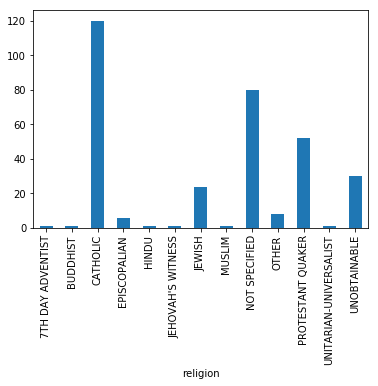

In [14]:
dysp_all_diag_hist_df.groupby('religion')['SUBJECT_ID'].nunique().plot(kind='bar')

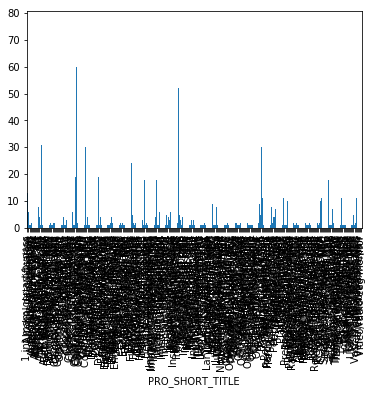

In [28]:
dysp_df.groupby('PRO_SHORT_TITLE')['SUBJECT_ID'].nunique().plot(kind='bar')